    PTM Citation:
    
    @InProceedings{Rombach_2022_CVPR,
        author    = {Rombach, Robin and Blattmann, Andreas and Lorenz, Dominik and Esser, Patrick and Ommer, Bj\"orn},
        title     = {High-Resolution Image Synthesis With Latent Diffusion Models},
        booktitle = {Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)},
        month     = {June},
        year      = {2022},
        pages     = {10684-10695}
    }


In [ ]:
import torch
from PIL import Image

In [ ]:
if torch.cuda.is_available():
    # Shows the nVidia GPUs, if this system has any
    !nvidia-smi

Tue Aug  5 16:09:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

  Using cached diffusers-0.11.1-py3-none-any.whl.metadata (29 kB)
Using cached diffusers-0.11.1-py3-none-any.whl (524 kB)
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.31.0
    Uninstalling diffusers-0.31.0:
      Successfully uninstalled diffusers-0.31.0


In [ ]:
# This is added to get around some issues of Torch not loading models correctly (test on Mac OS X and Kubuntu Linux)
!pip install --upgrade huggingface-hub==0.26.2 transformers==4.46.1 tokenizers==0.20.1 diffusers==0.31.0

  Using cached diffusers-0.31.0-py3-none-any.whl.metadata (18 kB)
Using cached diffusers-0.31.0-py3-none-any.whl (2.9 MB)
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.11.1
    Uninstalling diffusers-0.11.1:
      Successfully uninstalled diffusers-0.11.1


In [ ]:
if torch.cuda.is_available():
    device=torch.device("cuda")
elif torch.backends.mps.is_available():
    device=torch.device("mps")

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [ ]:
vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device)

In [ ]:
prompt = ["a photograph of a happy person"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

#generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

In [ ]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [ ]:
#latents = torch.randn(
#  (batch_size, unet.in_channels, height // 8, width // 8),
#  generator=generator,
#)
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
)
latents = latents.to(device)

/tmp/ipython-input-893387665.py:6: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [ ]:
latents.shape

torch.Size([1, 4, 64, 64])

In [ ]:
scheduler.set_timesteps(num_inference_steps)

In [ ]:
latents = latents * scheduler.init_noise_sigma

In [ ]:
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample

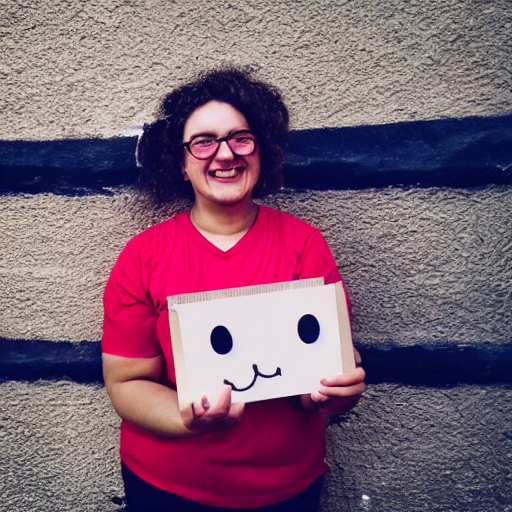

In [ ]:
from PIL import Image

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0].save("/content/drive/MyDrive/Stable_diffusion_project_folder/stable-diffusion/generated_synth_img.jpg")
pil_images[0]


In [ ]:
def generate_image(prompt):
  height = 512                        # default height of Stable Diffusion
  width = 512                         # default width of Stable Diffusion

  num_inference_steps = 100            # Number of denoising steps

  guidance_scale = 7.5                # Scale for classifier-free guidance

  batch_size = 1

  text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

  max_length = text_input.input_ids.shape[-1]
  uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
  )
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

  latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
  )
  latents = latents.to(device)

  scheduler.set_timesteps(num_inference_steps)

  latents = latents * scheduler.init_noise_sigma

  for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  # scale and decode the image latents with vae
  latents = 1 / 0.18215 * latents

  with torch.no_grad():
    image = vae.decode(latents).sample

  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  #pil_images[0].save("/content/drive/MyDrive/Stable_diffusion_project_folder/stable-diffusion/generated_synth_img_sad.jpg")
  #pil_images[0]
  return pil_images[0]

In [ ]:
for i in range(10):
  sad_image = generate_image("a photograph of a sad person")
  sad_file_path = "/content/drive/MyDrive/Stable_diffusion_project_folder/generated_images/sad/generated_synth_img_sad_" + str(i) + ".jpg"
  sad_image.save(sad_file_path)

  happy_image = generate_image("a photograph of a happy person")
  happy_file_path = "/content/drive/MyDrive/Stable_diffusion_project_folder/generated_images/happy/generated_synth_img_happy_" + str(i) + ".jpg"
  happy_image.save(happy_file_path)

  neutral_image = generate_image("a photograph of a neutral person")
  neutral_file_path = "/content/drive/MyDrive/Stable_diffusion_project_folder/generated_images/neutral/generated_synth_img_neutral_" + str(i) + ".jpg"
  neutral_image.save(neutral_file_path)

/tmp/ipython-input-2104370292.py:26: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]